In [1]:
!pip install mediapipe --upgrade -q
!pip install protobuf==4.25.3
!pip install arabic-reshaper python-bidi
!pip install -q pydot graphviz


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 12.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.22.1 requires google-cloud-bigquery-storage>=2.0.0, which is not installed.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.

In [2]:
import os
import warnings
import pickle
warnings.filterwarnings('ignore')

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Dense, Dropout, LayerNormalization, Input, Add,
    MultiHeadAttention, Embedding, SeparableConv1D, BatchNormalization
)
from datetime import datetime
from tensorflow.keras.metrics import top_k_categorical_accuracy


from tqdm import tqdm
import mediapipe as mp
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from bidi.algorithm import get_display
from arabic_reshaper import reshape
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display
import time



2026-01-17 19:32:51.469968: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768678371.662597      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768678371.723497      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768678372.187144      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768678372.187192      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768678372.187194      24 computation_placer.cc:177] computation placer alr

In [3]:
class Config:
    BASE_PATH = r"/kaggle/input/karsl-502"
    LABELS_PATH = r"/kaggle/input/labels/KARSL-502_Labels.xlsx" 
    OUTPUT_DIR = "output"  
    MODEL_DIR = "models"
    LOGS_DIR = "logs"
    CACHE_DIR = "cache"
    LANDMARKS_CACHE = "/kaggle/input/karsl502-holistic-landmarks/landmarks_dict.npy"
    DF_DATASET = "/kaggle/input/karsl502-dataframe/df_dataset_kaggle.csv"
    DF_LABELS = "/kaggle/input/karsl502-dataframe/df_labels.csv"
    DF_SIGN_TO_CLASS = "/kaggle/input/karsl502-dataframe/sign_to_class.pkl"

    NUM_FRAMES = 40 # std is 38 frames
    BATCH_SIZE = 32
    EPOCHS = 200
    LEARNING_RATE = 0.001

    AUGMENT = True
    TEMPORAL_JITTER = 0.1
    SPATIAL_NOISE = 0.02

    VALIDATION_SPLIT = 0.15
    PATIENCE = 20
    MIN_DELTA = 0.0001

    MP_CONFIDENCE = 0.5
    MAX_NUM_HANDS = 2

    USE_SUBSET = False
    SUBSET_CLASSES = 300

    USE_MIXED_PRECISION = True

    def __init__(self):
        for d in [self.OUTPUT_DIR, self.MODEL_DIR, self.LOGS_DIR, self.CACHE_DIR]:
            os.makedirs(d, exist_ok=True)

config = Config()

if config.USE_MIXED_PRECISION:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy('mixed_float16')
    print("✓ Mixed precision enabled")

✓ Mixed precision enabled


In [4]:
def normalize_sequence_length(seq, target_length):
    """Pad or truncate sequences to fixed length."""
    if len(seq) == 0:
        return np.zeros((target_length, seq.shape[1]), dtype=np.float32)
    if len(seq) < target_length:
        pad_len = target_length - len(seq)
        pad = np.repeat(seq[-1:], pad_len, axis=0)
        seq = np.concatenate([seq, pad], axis=0)
    elif len(seq) > target_length:
        indices = np.linspace(0, len(seq) - 1, target_length, dtype=int)
        seq = seq[indices]
    return seq.astype(np.float32)

def adjust_landmarks(arr, center):
    """Translate landmarks relative to a reference point (Nose or Wrist)."""
    # Check if the array is all zeros (meaning no detection)
    if np.all(arr == 0):
        return arr

    # Reshape the array to have shape (n, 3)
    # The Pose array is (33*3,) and hand arrays are (21*3,)
    arr_reshaped = arr.reshape(-1, 3)

    # Repeat the center array to have shape (n, 3)
    center_repeated = np.tile(center, (len(arr_reshaped), 1))

    # Subtract the center array from the arr array
    arr_adjusted = arr_reshaped - center_repeated

    # Reshape arr_adjusted back to shape (n*3,)
    arr_adjusted = arr_adjusted.reshape(-1)
    return arr_adjusted

def random_frame_drop(seq, drop_prob=0.1):
    """
    Randomly drop frames in the sequence with probability `drop_prob`,
    then normalize length to NUM_FRAMES.
    """
    mask = np.random.rand(len(seq)) > drop_prob
    dropped_seq = seq[mask]
    return normalize_sequence_length(dropped_seq, seq.shape[0])
def horizontal_flip(seq, flip_prob=0.5):
    """
    Flip landmarks horizontally around the vertical axis (X coordinate).
    Only do if sign semantics allow.
    """
    if np.random.rand() > flip_prob:
        return seq

    flipped_seq = seq.copy()
    coords = flipped_seq.reshape(len(seq), -1, 3)  # (T, 75, 3)

    # Flip X coordinates
    coords[..., 0] = 1.0 - coords[..., 0]  # assuming normalized 0..1

    # Swap left/right hand landmarks (33 pose + 21 LH + 21 RH)
    LH_idx = np.arange(33, 54)
    RH_idx = np.arange(54, 75)
    coords[:, LH_idx], coords[:, RH_idx] = coords[:, RH_idx].copy(), coords[:, LH_idx].copy()

    return coords.reshape(len(seq), -1)




def calculate_velocity_features(normalized_sequence):
    T, num_features = normalized_sequence.shape
    
    delta_features = np.diff(normalized_sequence, axis=0)
    
    # Handle the first frame (t=0)

    zero_delta = np.zeros((1, num_features), dtype=normalized_sequence.dtype)
    velocity_features = np.concatenate([zero_delta, delta_features], axis=0)
    
    # Concatenate Position and Velocity
    final_features = np.concatenate([normalized_sequence, velocity_features], axis=1)
    
    
    return final_features


def augment_sequence(seq, drop_prob=0.1, flip_prob=0.5, spatial_noise=0.02):
    augmented = seq.copy()
    
    # Spatial noise
    if spatial_noise > 0 and np.random.rand() < 0.5:
        noise = np.random.normal(0, spatial_noise, augmented.shape)
        augmented += noise

    # Frame dropping
    augmented = random_frame_drop(augmented, drop_prob)

    # Horizontal flipping
    augmented = horizontal_flip(augmented, flip_prob)
    
    return augmented


def normalize_landmarks(sequence):
    """
    Apply relative normalization (Nose/Wrist) only.
    Input sequence shape: (T, 225)
    """
    seq = sequence.copy()
    if seq.shape[0] == 0:
        return seq
    
    T, num_features = seq.shape
    normalized_seq = []
    
    for t in range(T):
        frame_features = seq[t, :]
        
        # 1. Pose features (0:99). Use Nose (first 3 coords) as center.
        pose = frame_features[0:99]
        nose = pose[0:3] 
        pose_adjusted = adjust_landmarks(pose, nose)
        
        # 2. Left Hand features (99:162). Use Left Wrist (first 3 coords of LH) as center.
        lh = frame_features[99:162]
        lh_wrist = lh[0:3]
        lh_adjusted = adjust_landmarks(lh, lh_wrist)
        
        # 3. Right Hand features (162:225). Use Right Wrist (first 3 coords of RH) as center.
        rh = frame_features[162:225]
        rh_wrist = rh[0:3]
        rh_adjusted = adjust_landmarks(rh, rh_wrist)
        
        # Concatenate adjusted features
        normalized_frame = np.concatenate([pose_adjusted, lh_adjusted, rh_adjusted])
        normalized_seq.append(normalized_frame)
        
    normalized_seq = np.array(normalized_seq, dtype=np.float32)

    #normalized_seq /= (np.max(np.abs(normalized_seq)) + 1e-6)
    
    return normalized_seq # Use pure relative coordinates

In [5]:
class LandmarkExtractor:
    def __init__(self, min_detection_confidence=0.5):
        # Initialize the Holistic model, NOT just Hands
        self.holistic_model = mp.solutions.holistic.Holistic(
            min_detection_confidence=min_detection_confidence,
            min_tracking_confidence=min_detection_confidence
        )
        # 33 pose * 3 + 21 lh * 3 + 21 rh * 3 = 225 features
        self.num_landmarks = (33 + 21 + 21) * 3 

    def extract(self, frame):
        try:
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            rgb_frame.flags.writeable = False # For performance
            results = self.holistic_model.process(rgb_frame)
            rgb_frame.flags.writeable = True

            # Initialize keypoint arrays with zeros
            pose_landmarks = np.zeros(33 * 3, dtype=np.float32)
            lh_landmarks = np.zeros(21 * 3, dtype=np.float32)
            rh_landmarks = np.zeros(21 * 3, dtype=np.float32)

            # Extract Pose
            if results.pose_landmarks:
                pose_landmarks = np.array([[lm.x, lm.y, lm.z] for lm in results.pose_landmarks.landmark]).flatten()
            
            # Extract Left Hand
            if results.left_hand_landmarks:
                lh_landmarks = np.array([[lm.x, lm.y, lm.z] for lm in results.left_hand_landmarks.landmark]).flatten()
            
            # Extract Right Hand
            if results.right_hand_landmarks:
                rh_landmarks = np.array([[lm.x, lm.y, lm.z] for lm in results.right_hand_landmarks.landmark]).flatten()
            
            # Concatenate all features
            landmarks = np.concatenate([pose_landmarks, lh_landmarks, rh_landmarks])
            
            return landmarks

        except Exception as e:
            # print(f"Error during extraction: {e}")
            return np.zeros(self.num_landmarks, dtype=np.float32)

    def close(self):
        self.holistic_model.close()

In [6]:
def load_dataset(config):
    df_labels = pd.read_excel(config.LABELS_PATH)
    if config.USE_SUBSET:
        df_labels = df_labels[df_labels['SignID'] <= config.SUBSET_CLASSES]
    sign_to_class = dict(zip(df_labels['Sign-Arabic'], df_labels['SignID']-1))

    data_info = []
    for speaker in tqdm(os.listdir(config.BASE_PATH)):
        speaker_outer = os.path.join(config.BASE_PATH, speaker)
        speaker_path = os.path.join(speaker_outer, speaker) #speaker_outer (if locally)
        if not os.path.exists(speaker_path):
            continue
        for split in ['train', 'test']:
            split_path = os.path.join(speaker_path, split)
            if not os.path.exists(split_path):
                continue
            for video_folder in sorted(os.listdir(split_path)):
                folder_path = os.path.join(split_path, video_folder)
                if not os.path.isdir(folder_path):
                    continue
                try:
                    sign_id = int(video_folder)
                    if config.USE_SUBSET and sign_id > config.SUBSET_CLASSES:
                        continue
                    label = df_labels.loc[df_labels['SignID']==sign_id, 'Sign-Arabic'].values[0]
                    class_id = sign_to_class[label]
                    for sample_subfolder in os.listdir(folder_path):
                        sample_path = os.path.join(folder_path, sample_subfolder)
                        # recommending commenting this out if you are not running analyze on full dataset
                        frame_files = [
                            f for f in os.listdir(sample_path)
                            if f.lower().endswith(('.jpg', '.jpeg', '.png')) # all are .jpg but just in case
                        ]
                        num_frames = len(frame_files)
                        if os.path.isdir(sample_path):
                            data_info.append({
                                'speaker': speaker,
                                'split': split,
                                'video_folder': video_folder,
                                'sample_path': sample_path,
                                'Sign-Arabic': label,
                                'class_id': class_id, # added this because of merging landmarks (no overlapping, could be removed if one run, or running cell of rekeying)
                                'num_frames': num_frames

                            })
                except:
                    continue

    df_dataset = pd.DataFrame(data_info)
    # Add a static idx column (unique per row)
    df_dataset = df_dataset.reset_index(drop=True)
    df_dataset['idx'] = df_dataset.index
    
    return df_dataset, df_labels, sign_to_class

def preprocess_landmarks(df_dataset, num_frames, n_workers=None):
    landmarks_dict = {}
    
    extractor = LandmarkExtractor(min_detection_confidence=config.MP_CONFIDENCE)
    
    try:
        for idx, row in tqdm(df_dataset.iterrows(), total=len(df_dataset), desc="Extracting landmarks"):
            sample_path = row['sample_path']
            
            try:
                frame_files = sorted(
                    [f for f in os.listdir(sample_path) if f.lower().endswith(('.jpg', '.png'))],
                    key=lambda x: int(''.join(filter(str.isdigit, x))) if any(c.isdigit() for c in x) else x
                )
                
                seq = []
                for f in frame_files:
                    frame = cv2.imread(os.path.join(sample_path, f))
                    if frame is not None:
                        seq.append(extractor.extract(frame))
                
                if seq:
                    seq = np.array(seq)
                    seq = normalize_sequence_length(seq, num_frames)
                    landmarks_dict[idx] = seq
            except Exception as e:
                # Skip failed samples silently
                continue
    finally:
        extractor.close()
    
    return landmarks_dict

In [7]:
if os.path.exists(config.DF_DATASET):
    df_dataset = pd.read_csv(config.DF_DATASET)
    df_labels = pd.read_csv(config.DF_LABELS)
    with open(config.DF_SIGN_TO_CLASS, "rb") as f:
        sign_to_class = pickle.load(f)
else:
    df_dataset, df_labels, sign_to_class = load_dataset(config)

In [8]:
print(df_dataset.describe())
print(df_dataset.tail())

            speaker  video_folder      class_id    num_frames           idx
count  75515.000000  75515.000000  75515.000000  75515.000000  75515.000000
mean       1.999669    251.123459    250.123459     40.939403  37757.000000
std        0.815331    145.050091    145.050091     15.406740  21799.447126
min        1.000000      1.000000      0.000000      5.000000      0.000000
25%        1.000000    126.000000    125.000000     31.000000  18878.500000
50%        2.000000    251.000000    250.000000     38.000000  37757.000000
75%        3.000000    377.000000    376.000000     49.000000  56635.500000
max        3.000000    502.000000    501.000000    269.000000  75514.000000
       speaker split  video_folder  \
75510        3  test           502   
75511        3  test           502   
75512        3  test           502   
75513        3  test           502   
75514        3  test           502   

                                             sample_path Sign-Arabic  \
75510  /kaggle/

In [9]:
def analyze_dataset_from_df(df_dataset, df_labels):
    """Comprehensive dataset analysis from a prebuilt dataframe."""
    print("="*80)
    print("DATASET ANALYSIS (from df)")
    print("="*80)

    sign_to_class = dict(zip(df_labels['Sign-Arabic'], df_labels['SignID']-1))
    
    # --- BASIC DATA STATS ---
    print("\n=== OVERALL STATISTICS ===")
    print(f"Total samples: {len(df_dataset)}")
    print(f"Number of classes: {df_dataset['Sign-Arabic'].nunique()}")
    print(f"Number of speakers: {df_dataset['speaker'].nunique()}")
    print(f"\nFrame statistics:")
    print(f"  Min: {df_dataset['num_frames'].min()}")
    print(f"  Max: {df_dataset['num_frames'].max()}")
    print(f"  Mean: {df_dataset['num_frames'].mean():.2f}")
    print(f"  Median: {df_dataset['num_frames'].median():.2f}")
    print(f"  Std: {df_dataset['num_frames'].std():.2f}")

    # --- PER SPLIT ---
    print("\n=== PER-SPLIT STATISTICS ===")
    split_stats = df_dataset.groupby('split').agg({
        'num_frames': ['min', 'max', 'mean', 'median', 'std'],
        'class_id': 'count'
    })
    print(split_stats)

    # --- PER SPEAKER ---
    print("\n=== PER-SPEAKER STATISTICS ===")
    speaker_stats = df_dataset.groupby('speaker').agg({
        'num_frames': ['mean', 'std', 'min', 'max'],
        'class_id': 'count'
    })
    print(speaker_stats)

    # --- CLASS DISTRIBUTION ---
    print("\n=== CLASS DISTRIBUTION ===")
    class_dist = df_dataset.groupby(['split', 'Sign-Arabic']).size().unstack(fill_value=0)
    print(f"Classes with samples: {(class_dist.sum(axis=0) > 0).sum()}")

    # Class imbalance
    train_class_counts = df_dataset[df_dataset['split'] == 'train']['class_id'].value_counts()
    imbalance_ratio = train_class_counts.max() / train_class_counts.min()
    print(f"Class imbalance ratio (max/min): {imbalance_ratio:.2f}")

    plt.rcdefaults()

    # --- VISUALIZATION ---
    fig, axes = plt.subplots(3, 2, figsize=(16, 16))

    # Histogram of frames (ALL)
    axes[0, 0].hist(df_dataset['num_frames'], bins=50)
    axes[0, 0].set_title('Distribution of Frame Counts (All Samples)')
    axes[0, 0].set_xlabel('Number of Frames')
    axes[0, 0].set_ylabel('Frequency')

    # Frame distribution 
    frames = df_dataset['num_frames'].values
    # Compute percentiles
    p25 = np.percentile(frames, 25)
    p50 = np.percentile(frames, 50)
    p75 = np.percentile(frames, 75)
    # Plot histogram
    axes[0, 1].hist(frames, bins=50)
    axes[0, 1].set_title('Frame Count Distribution (All Samples)')
    axes[0, 1].set_xlabel('Number of Frames')
    axes[0, 1].set_ylabel('Frequency')
    # Add percentile lines
    axes[0, 1].axvline(p25, color='orange', linestyle='--', label='25%')
    axes[0, 1].axvline(p50, color='green', linestyle='--', label='50% (Median)')
    axes[0, 1].axvline(p75, color='red', linestyle='--', label='75%')
    axes[0, 1].legend()

    # Boxplot by speaker
    df_dataset.boxplot(column='num_frames', by='speaker', ax=axes[1, 0])
    axes[1, 0].set_title('Frame Count Distribution by Speaker')
    axes[1, 0].set_xlabel('Speaker')
    axes[1, 0].set_ylabel('Number of Frames')

    # Samples per split
    split_counts = df_dataset['split'].value_counts()
    axes[1, 1].bar(split_counts.index, split_counts.values)
    axes[1, 1].set_title('Samples per Split')
    axes[1, 1].set_ylabel('Number of Samples')

    # Class frequency top 20
    top_classes = df_dataset['Sign-Arabic'].value_counts().head(20)
    arabic_labels = [get_display(reshape(str(label))) for label in top_classes.index]

    axes[2, 0].barh(arabic_labels, top_classes.values)
    axes[2, 0].set_title('Top 20 Most Frequent Classes')
    axes[2, 0].set_xlabel('Number of Samples')

    # hide empty subplot
    axes[2, 1].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(config.OUTPUT_DIR, 'dataset_analysis.png'), dpi=300, bbox_inches='tight')
    print(f"\n✓ Visualization saved to {config.OUTPUT_DIR}/dataset_analysis.png")

    df_dataset.to_csv(os.path.join(config.OUTPUT_DIR, 'dataset_manifest.csv'), index=False)
    print(f"✓ Dataset manifest saved to {config.OUTPUT_DIR}/dataset_manifest.csv")


DATASET ANALYSIS (from df)

=== OVERALL STATISTICS ===
Total samples: 75515
Number of classes: 502
Number of speakers: 3

Frame statistics:
  Min: 5
  Max: 269
  Mean: 40.94
  Median: 38.00
  Std: 15.41

=== PER-SPLIT STATISTICS ===
      num_frames                                   class_id
             min  max       mean median        std    count
split                                                      
test          11  140  40.969284   38.0  15.472217    12046
train          5  269  40.933731   38.0  15.394398    63469

=== PER-SPEAKER STATISTICS ===
        num_frames                     class_id
              mean        std min  max    count
speaker                                        
1        41.245182  15.095983   5  117    25112
2        35.112340  12.898535  10  269    25316
3        46.513573  15.908687   5  145    25087

=== CLASS DISTRIBUTION ===
Classes with samples: 502
Class imbalance ratio (max/min): 1.68

✓ Visualization saved to output/dataset_analysis.png
✓

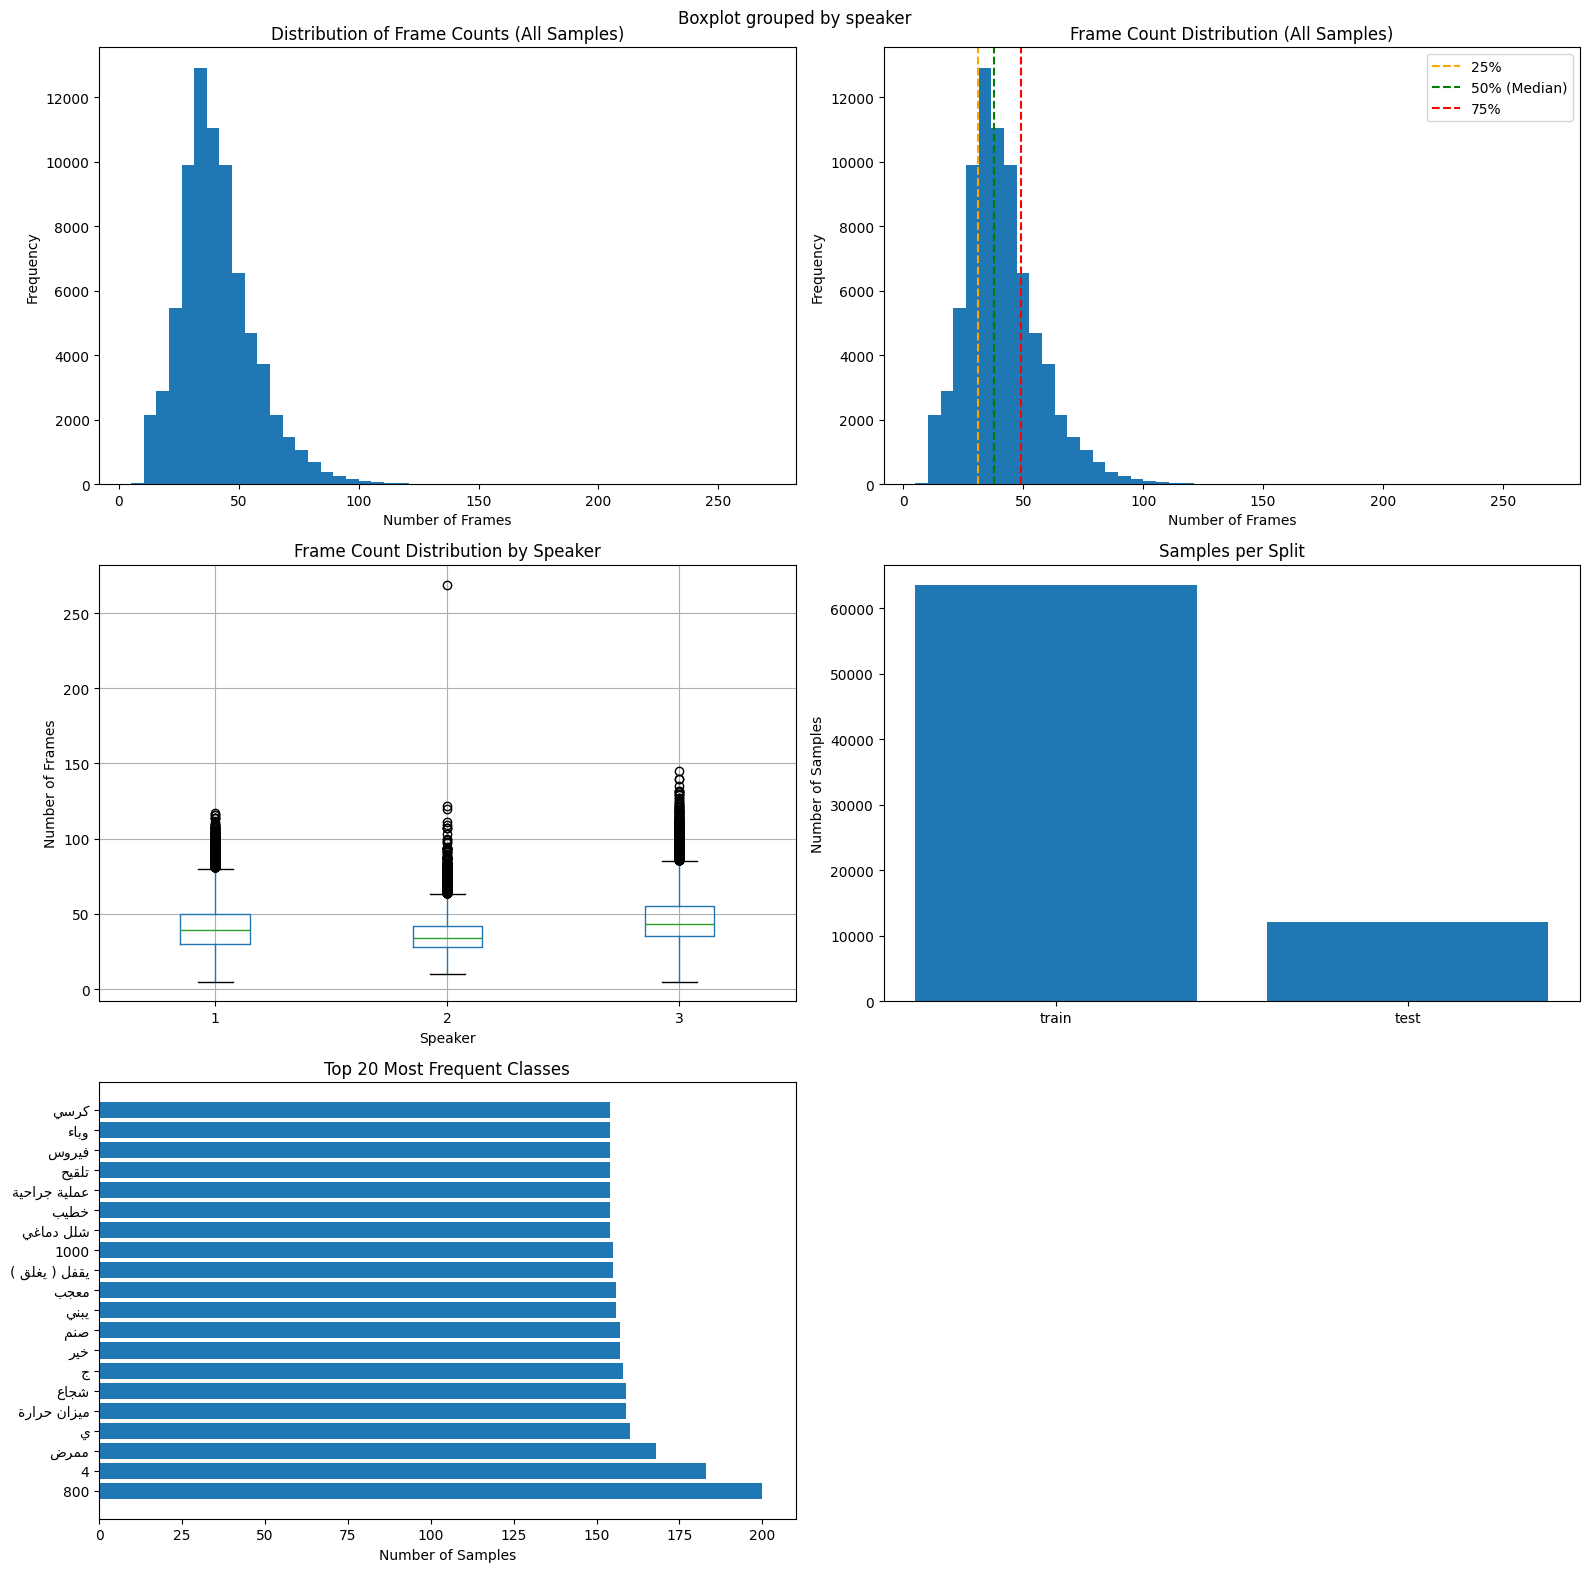

In [10]:
analyze_dataset_from_df(df_dataset, df_labels)

In [11]:
# Check if cached landmarks exist (FOR 502-CLASS RUN)
if os.path.exists(config.LANDMARKS_CACHE):
    print(f"Loading cached landmarks from {config.LANDMARKS_CACHE}")
    landmarks_dict = np.load(config.LANDMARKS_CACHE, allow_pickle=True).item()
    print(f"✓ Loaded {len(landmarks_dict)} landmark sequences from cache")
else:
    print("Extracting landmarks (this will take time)...")
    landmarks_dict = preprocess_landmarks(df_dataset, config.NUM_FRAMES)
    
    # Save to cache
    print(f"Saving landmarks to {config.LANDMARKS_CACHE}")
    np.save(config.LANDMARKS_CACHE, landmarks_dict)
    print(f"✓ Saved {len(landmarks_dict)} landmark sequences to cache")

Loading cached landmarks from /kaggle/input/karsl502-holistic-landmarks/landmarks_dict.npy
✓ Loaded 75515 landmark sequences from cache



=== Visualizing Sample Landmarks from landmarks_dict ===
Sample: يشم (Class 165)
Path: /kaggle/input/karsl-502/01/01/train/0166/03_01_0166_(17_04_17_18_40_26)_c
Frame: 03_01_0166_(17_04_17_18_40_26)_c_0022.jpg (22/43)


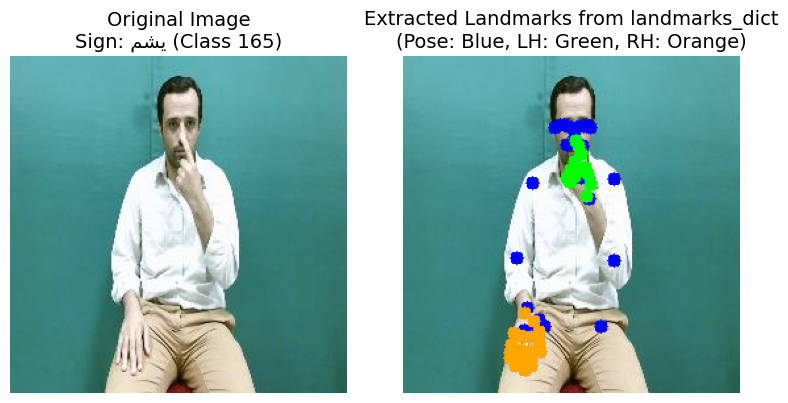


Landmark statistics for frame 21:
  Shape: (225,)
  Min: -1.0607, Max: 1.4674
  Mean: 0.3236, Std: 0.4168
  Non-zero values: 225/225


Sample: يشم (Class 165)
Path: /kaggle/input/karsl-502/01/01/train/0166/03_01_0166_(17_04_17_18_40_30)_c
Frame: 03_01_0166_(17_04_17_18_40_30)_c_0026.jpg (26/50)


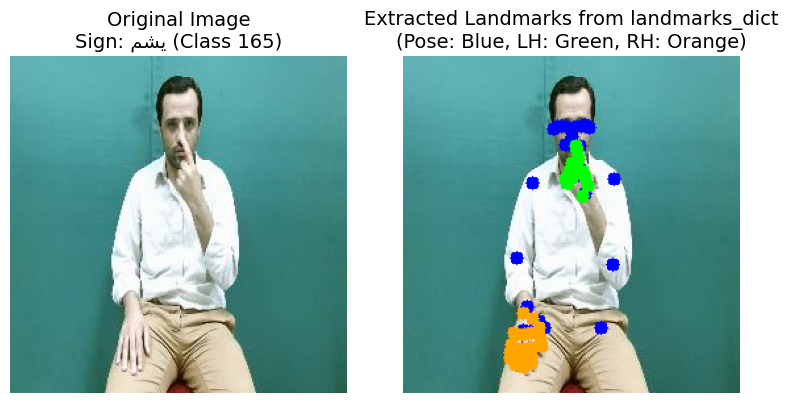


Landmark statistics for frame 25:
  Shape: (225,)
  Min: -1.0745, Max: 1.4751
  Mean: 0.3246, Std: 0.4169
  Non-zero values: 225/225


Sample: يشم (Class 165)
Path: /kaggle/input/karsl-502/01/01/train/0166/03_01_0166_(17_04_17_18_40_33)_c
Frame: 03_01_0166_(17_04_17_18_40_33)_c_0025.jpg (25/49)


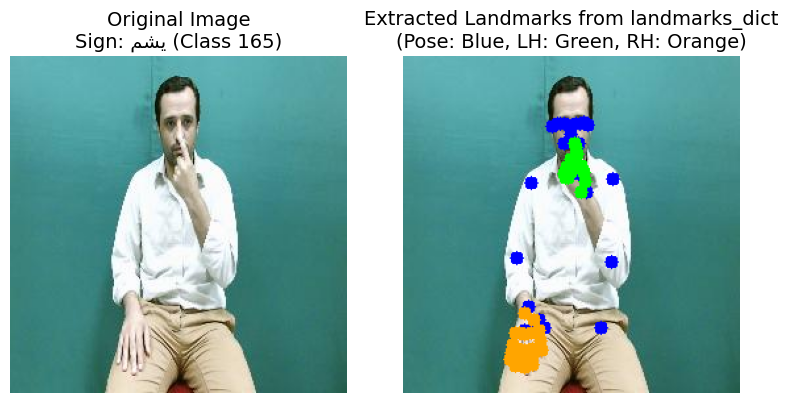


Landmark statistics for frame 24:
  Shape: (225,)
  Min: -1.1447, Max: 1.4722
  Mean: 0.3238, Std: 0.4185
  Non-zero values: 225/225


Sample: يشم (Class 165)
Path: /kaggle/input/karsl-502/01/01/train/0166/03_01_0166_(17_04_17_18_40_37)_c
Frame: 03_01_0166_(17_04_17_18_40_37)_c_0023.jpg (23/45)


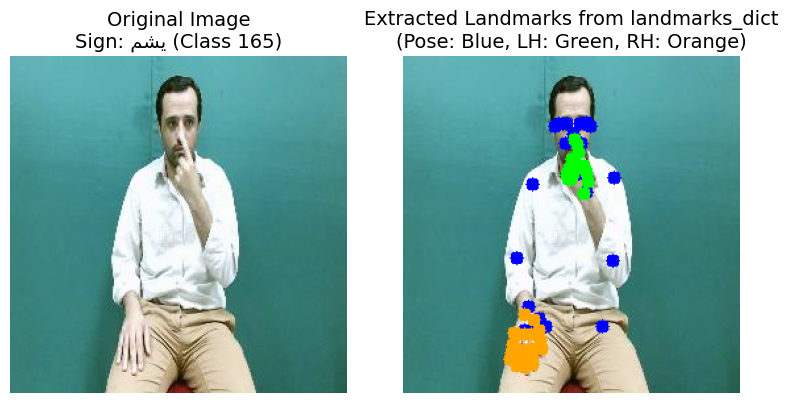


Landmark statistics for frame 22:
  Shape: (225,)
  Min: -1.1074, Max: 1.4676
  Mean: 0.3229, Std: 0.4161
  Non-zero values: 225/225


Sample: يشم (Class 165)
Path: /kaggle/input/karsl-502/01/01/train/0166/03_01_0166_(17_04_17_18_40_41)_c
Frame: 03_01_0166_(17_04_17_18_40_41)_c_0023.jpg (23/44)


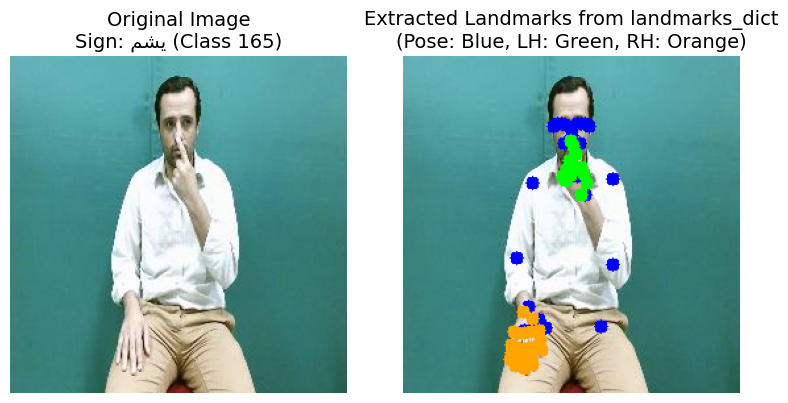


Landmark statistics for frame 22:
  Shape: (225,)
  Min: -1.1610, Max: 1.4542
  Mean: 0.3202, Std: 0.4207
  Non-zero values: 225/225




In [12]:


def plot_landmarks_from_dict(sample_idx, frame_idx=None):
    """
    Plot landmarks from landmarks_dict overlaid on the original image
    
    Args:
        sample_idx: Index in landmarks_dict
        frame_idx: Which frame to visualize (None = middle frame)
    """
    # Get sample info
    row = df_dataset.loc[sample_idx]
    sample_path = row['sample_path']
    
    print(f"Sample: {row['Sign-Arabic']} (Class {row['class_id']})")
    print(f"Path: {sample_path}")
    
    # Get frame files
    frame_files = sorted(
        [f for f in os.listdir(sample_path) if f.lower().endswith(('.jpg', '.png'))],
        key=lambda x: int(''.join(filter(str.isdigit, x))) if any(c.isdigit() for c in x) else x
    )
    
    # Select frame to visualize
    if frame_idx is None:
        frame_idx = len(frame_files) // 2  # Middle frame
    
    frame_path = os.path.join(sample_path, frame_files[frame_idx])
    print(f"Frame: {frame_files[frame_idx]} ({frame_idx+1}/{len(frame_files)})")
    
    # Load image
    image = cv2.imread(frame_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image_rgb.shape[:2]
    
    # Get landmarks from landmarks_dict 
    landmarks = landmarks_dict[sample_idx][frame_idx]  # Shape: (225,)
    
    # Reshape to get coordinates: (75 landmarks, 3 coords)
    landmarks_reshaped = landmarks.reshape(75, 3)
    
    # Split into pose, left hand, right hand
    pose_lm = landmarks_reshaped[:33]      # 33 pose landmarks
    lh_lm = landmarks_reshaped[33:54]      # 21 left hand landmarks
    rh_lm = landmarks_reshaped[54:75]      # 21 right hand landmarks
    
    # Create annotated image
    annotated_image = image_rgb.copy()
    # Define colors as RGB (R, G, B) since annotated_image is in RGB
    COLOR_POSE = (0, 0, 255)       #  Blue
    COLOR_LH = (0, 255, 0)         #  Green
    COLOR_RH = (255, 165, 0)       #  Orange
    # Draw pose landmarks (blue)
    for i, (x, y, z) in enumerate(pose_lm):
        if x > 0 and y > 0:  # Only draw if detected
            px, py = int(x * w), int(y * h)
            cv2.circle(annotated_image, (px, py), 5, COLOR_POSE, -1)
    
    # Draw left hand landmarks (green)
    for i, (x, y, z) in enumerate(lh_lm):
        if x > 0 and y > 0:
            px, py = int(x * w), int(y * h)
            cv2.circle(annotated_image, (px, py), 5, COLOR_LH, -1)
    
    # Draw right hand landmarks (orange)
    for i, (x, y, z) in enumerate(rh_lm):
        if x > 0 and y > 0:
            px, py = int(x * w), int(y * h)
            cv2.circle(annotated_image, (px, py), 5, COLOR_RH, -1)
    
    # Plot side by side
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    axes[0].imshow(image_rgb)
    arabic_label = get_display(reshape(str(row["Sign-Arabic"])))
    axes[0].set_title(f'Original Image\nSign: {arabic_label} (Class {row["class_id"]})', fontsize=14)
    axes[0].axis('off')
    
    axes[1].imshow(annotated_image)
    axes[1].set_title(f'Extracted Landmarks from landmarks_dict\n(Pose: Blue, LH: Green, RH: Orange)', fontsize=14)
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Show landmark statistics
    print(f"\nLandmark statistics for frame {frame_idx}:")
    print(f"  Shape: {landmarks.shape}")
    print(f"  Min: {landmarks.min():.4f}, Max: {landmarks.max():.4f}")
    print(f"  Mean: {landmarks.mean():.4f}, Std: {landmarks.std():.4f}")
    print(f"  Non-zero values: {np.count_nonzero(landmarks)}/{len(landmarks)}")

# ===== VISUALIZE SAMPLES =====
print("\n=== Visualizing Sample Landmarks from landmarks_dict ===")

# Plot 10 samples
for sample_idx in list(landmarks_dict.keys())[7000:7005]:
    plot_landmarks_from_dict(sample_idx)
    print("\n" + "="*80 + "\n")


In [13]:
class SignLanguageGenerator(tf.keras.utils.Sequence):
    def __init__(self, df_samples, landmarks_dict, num_classes, batch_size=32, augment=False, shuffle=True):
        self.df_samples = df_samples.reset_index(drop=True)  # CRITICAL: Reset index to 0,1,2,3...
        self.landmarks_dict = landmarks_dict
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        
        # Map new sequential indices to original indices in landmarks_dict
        self.index_mapping = {}
        for new_idx, orig_idx in enumerate(df_samples.index):
            if orig_idx in landmarks_dict:
                self.index_mapping[new_idx] = orig_idx
        
        self.valid_indices = list(self.index_mapping.keys())
        if self.shuffle:
            np.random.shuffle(self.valid_indices)

    def __len__(self):
        return int(np.ceil(len(self.valid_indices) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.valid_indices[idx*self.batch_size:(idx+1)*self.batch_size]
        X_batch, y_batch = [], []
        
        for new_idx in batch_indices:
            # Get original index from mapping
            orig_idx = self.index_mapping[new_idx]
            
            # Get the row from the reset dataframe
            row = self.df_samples.iloc[new_idx]
            
            # Get sequence using original index
            seq = normalize_landmarks(self.landmarks_dict[orig_idx].copy())
            
            if self.augment:
                seq = augment_sequence(seq, config.SPATIAL_NOISE)

            
            seq = calculate_velocity_features(seq) 
            
            X_batch.append(seq)
            y_batch.append(row['class_id'])
        
        return np.array(X_batch, dtype=np.float32), tf.keras.utils.to_categorical(y_batch, num_classes=self.num_classes)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.valid_indices)

In [14]:


def transformer_encoder_block(inputs, head_size, num_heads, ff_dim, dropout=0.3):
    # Layer normalization 1
    x = LayerNormalization(epsilon=1e-6)(inputs)
    
    # Multi-head attention
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    
    # Skip connection 1
    res = x + inputs
    
    # Layer normalization 2
    x = LayerNormalization(epsilon=1e-6)(res)
    
    # Feed-forward network
    x = Dense(ff_dim, activation="gelu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x) # Output dimension matches input
    
    # Skip connection 2
    return Add()([x, res])
    
def create_realtime_model(num_frames, num_features, num_classes):
    inputs = Input(shape=(num_frames, num_features))
    
    # ============= EFFICIENT MULTI-SCALE FEATURE EXTRACTION =============
    # Use DEPTHWISE SEPARABLE convolutions (much faster on CPU)
    
    # Path 1: Fine-grained
    conv1 = SeparableConv1D(96, kernel_size=3, padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = tf.keras.layers.Activation('gelu')(conv1)
    
    # Path 2: Medium-grained
    conv2 = SeparableConv1D(96, kernel_size=5, padding='same')(inputs)
    conv2 = BatchNormalization()(conv2)
    conv2 = tf.keras.layers.Activation('gelu')(conv2)
    
    # Concatenate (192 channels total)
    x = tf.keras.layers.Concatenate()([conv1, conv2])
    x = Dropout(0.2)(x)
    
    # Dimension projection (instead of Path 3 + concatenation)
    x = SeparableConv1D(192, kernel_size=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Activation('gelu')(x)
    
    # ============= EFFICIENT RESIDUAL BLOCK =============
    # Only 1 residual block (instead of 2)
    residual = x
    
    x = SeparableConv1D(192, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.Activation('gelu')(x)
    x = Dropout(0.2)(x)
    
    x = SeparableConv1D(192, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, residual])
    x = tf.keras.layers.Activation('gelu')(x)
    
    # ============= POSITIONAL ENCODING =============
    positions = tf.range(start=0, limit=num_frames, delta=1)
    position_embedding = Embedding(input_dim=num_frames, output_dim=192)(positions)
    x = x + position_embedding
    
    # ============= EFFICIENT DUAL TRANSFORMER BLOCKS =============
    # 2 transformer blocks with 4 heads (not 8)
    
    x = transformer_encoder_block(x, head_size=112, num_heads=4, ff_dim=320, dropout=0.15)
    x = transformer_encoder_block(x, head_size=112, num_heads=4, ff_dim=320, dropout=0.15)

    
    # ============= EFFICIENT ATTENTION POOLING =============
    # Simpler attention mechanism (faster than query-key-value)
    
    attention_weights = Dense(1, activation='tanh')(x)
    attention_weights = tf.keras.layers.Softmax(axis=1)(attention_weights)
    x = tf.keras.layers.Multiply()([x, attention_weights])
    
    # Combined pooling
    x_avg = tf.keras.layers.GlobalAveragePooling1D()(x)
    x_max = tf.keras.layers.GlobalMaxPooling1D()(x)
    x = tf.keras.layers.Concatenate()([x_avg, x_max])  # (384,)
    
    # ============= COMPACT CLASSIFICATION HEAD =============
    x = Dense(320, activation='gelu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    
    x = Dense(192, activation='gelu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = Dense(128, activation='gelu')(x)
    x = Dropout(0.3)(x)
    
    outputs = Dense(num_classes, activation='softmax', dtype='float32')(x)
    
    model = Model(inputs, outputs)
    return model




In [15]:
def cosine_decay_with_warmup(epoch, lr):
    initial_lrate = 1e-3
    total_epochs = config.EPOCHS
    warmup_epochs = 5  # Optional: helps stabilize the Transformer at the start
    
    if epoch < warmup_epochs:
        return initial_lrate * (epoch + 1) / warmup_epochs
    
    # Cosine formula
    cosine_decay = 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs)))
    return initial_lrate * cosine_decay

In [16]:
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)
    
def top_10_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=10)
num_classes = config.SUBSET_CLASSES if config.USE_SUBSET else 502

In [17]:
# loso_results = []
# gkf = GroupKFold(n_splits=3)
# is_target_fold = True
# TARGET_FOLD = 3 # run only fold 3
# for fold_id, (train_idx, test_idx) in enumerate(
#         gkf.split(df_dataset, groups=df_dataset['speaker']), start=1):
#     if is_target_fold and fold_id != TARGET_FOLD:
#         continue
#     test_speaker = df_dataset.iloc[test_idx]['speaker'].unique()[0]
#     print(f"\n=== LOSO Fold {fold_id} (Leaving out speaker: {test_speaker}) ===")

#     train_df = df_dataset.iloc[train_idx]   # Training on other speakers
#     test_df  = df_dataset.iloc[test_idx]    # Testing on the left-out speaker

#     train_df_fold, val_df_fold = train_test_split(
#                                     train_df,
#                                     test_size=config.VALIDATION_SPLIT,
#                                     stratify=train_df['class_id'],
#                                     random_state=42
#                                 )
#     # Generators
#     train_gen = SignLanguageGenerator(
#                     train_df_fold, landmarks_dict, num_classes,
#                     config.BATCH_SIZE, augment=True, shuffle=True
#                 )
                
#     val_gen = SignLanguageGenerator(
#         val_df_fold, landmarks_dict, num_classes,
#         config.BATCH_SIZE, augment=False, shuffle=False
#     )

#     test_gen = SignLanguageGenerator(
#         test_df, landmarks_dict, num_classes,
#         config.BATCH_SIZE, augment=False, shuffle=False
#     )

#     # Compute class weights PER FOLD
#     cw = compute_class_weight(
#         class_weight='balanced',
#         classes=np.unique(train_df_fold['class_id']),
#         y=train_df_fold['class_id']
#     )
#     class_weights = dict(enumerate(cw))

#     # Model
#     model = create_realtime_model(config.NUM_FRAMES, 450, num_classes)
#     model.compile(
#         optimizer=Adam(config.LEARNING_RATE),
#         loss='categorical_crossentropy',
#         metrics=['accuracy', top_5_accuracy, top_10_accuracy]
#     )

#     # Callbacks
#     callbacks = [
#         EarlyStopping(monitor='val_loss', patience=config.PATIENCE, min_delta=config.MIN_DELTA, restore_best_weights=True),
#         LearningRateScheduler(cosine_decay_with_warmup, verbose=0)
#     ]

#     # Train
#     model.fit(
#         train_gen,
#         epochs=config.EPOCHS,
#         callbacks=callbacks,
#         class_weight=class_weights,
#         verbose=0 # no output because of max 200 epoch * 3 [output limits]
#     )

#     # Evaluate
#     y_true, y_pred = [], []
#     y_true_onehot, y_pred_probs = [], []

#     for i in range(len(test_gen)):
#         Xb, yb = test_gen[i]
#         preds = model.predict(Xb, verbose=0)
#         y_true.extend(np.argmax(yb, axis=1))
#         y_pred.extend(np.argmax(preds, axis=1))
#         y_true_onehot.append(yb)
#         y_pred_probs.append(preds)

#     y_true_onehot = np.vstack(y_true_onehot)
#     y_pred_probs = np.vstack(y_pred_probs)

#     # Calculate Top-1, Top-5, Top-10 manually
#     top1 = np.mean(np.array(y_true) == np.array(y_pred))
#     top5 = np.mean([np.argmax(y_true_onehot[i]) in np.argsort(y_pred_probs[i])[-5:] for i in range(len(y_true))])
#     top10 = np.mean([np.argmax(y_true_onehot[i]) in np.argsort(y_pred_probs[i])[-10:] for i in range(len(y_true))])

#     loso_results.append({
#         'fold': fold_id,
#         'speaker': test_speaker,
#         'top1': top1,
#         'top5': top5,
#         'top10': top10
#     })

#     print(f"Fold {fold_id} | Speaker: {test_speaker} → Top-1: {top1*100:.2f}%, Top-5: {top5*100:.2f}%, Top-10: {top10*100:.2f}%")
# if is_target_fold == False:
#     # Aggregate results
#     top1_mean = np.mean([r['top1'] for r in loso_results])
#     top5_mean = np.mean([r['top5'] for r in loso_results])
#     top10_mean = np.mean([r['top10'] for r in loso_results])
    
#     print(f"\nLOSO Mean Accuracy → Top-1: {top1_mean*100:.2f}%, Top-5: {top5_mean*100:.2f}%, Top-10: {top10_mean*100:.2f}%")
#     loso_df = pd.DataFrame(loso_results)

#     # Save to CSV
#     output_csv = os.path.join(config.OUTPUT_DIR, "loso_results.csv")
#     loso_df.to_csv(output_csv, index=False, encoding='utf-8-sig')
    
#     print(f"✓ LOSO results saved to {output_csv}")
# else:
#     # THIS IS 2ND RUN i.e. It was ran previously.
#     loso_results_hardcoded = [
#         {"fold": 1, "speaker": 2, "top1": 0.4992, "top5": 0.7230, "top10": 0.7969},
#         {"fold": 2, "speaker": 1, "top1": 0.7018, "top5": 0.8797, "top10": 0.9231},
#     ]
    
#     # Add your current fold (fold 3) result
#     loso_results_hardcoded.extend(loso_results)
    
#     # Mean calculation (manual + hard-coded)
#     top1_mean = np.mean([r['top1'] for r in loso_results_hardcoded])
#     top5_mean = np.mean([r['top5'] for r in loso_results_hardcoded])
#     top10_mean = np.mean([r['top10'] for r in loso_results_hardcoded])
    
#     print(f"\nLOSO Mean Accuracy → Top-1: {top1_mean*100:.2f}%, Top-5: {top5_mean*100:.2f}%, Top-10: {top10_mean*100:.2f}%")
#     loso_df = pd.DataFrame(loso_results_hardcoded)

#     # Save to CSV
#     output_csv = os.path.join(config.OUTPUT_DIR, "loso_results.csv")
#     loso_df.to_csv(output_csv, index=False, encoding='utf-8-sig')
    
#     print(f"✓ LOSO results saved to {output_csv}")





In [18]:
train_df = df_dataset[df_dataset['split']=='train']
test_df = df_dataset[df_dataset['split']=='test']
train_samples, val_samples = train_test_split(train_df, test_size=config.VALIDATION_SPLIT,
                                              stratify=train_df['class_id'], random_state=42)

train_gen = SignLanguageGenerator(train_samples, landmarks_dict, num_classes, config.BATCH_SIZE, True, True) 
val_gen = SignLanguageGenerator(val_samples, landmarks_dict, num_classes, config.BATCH_SIZE, False, False)
test_gen = SignLanguageGenerator(test_df, landmarks_dict, num_classes, config.BATCH_SIZE, False, False)



I0000 00:00:1768678405.511578      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1768678405.515447      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 40, 450)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv1d    │ (None, 40, 96)    │     44,646 │ input_layer[0][0] │
│ (SeparableConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv1d_1  │ (None, 40, 96)    │     45,546 │ input_layer[0][0] │
│ (SeparableConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 40, 96)    │        384 │ separable_conv1d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 96)    │        384 │ separable_conv1d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 40, 96)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 40, 96)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 40, 192)   │          0 │ activation[0][0], │
│ (Concatenate)       │                   │            │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 40, 192)   │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv1d_2  │ (None, 40, 192)   │     37,248 │ dropout[0][0]     │
│ (SeparableConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 192)   │        768 │ separable_conv1d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 40, 192)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv1d_3  │ (None, 40, 192)   │     37,632 │ activation_2[0][… │
│ (SeparableConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 192)   │        768 │ separable_conv1d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 40, 192)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 40, 192)   │          0 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv1d_4  │ (None, 40, 192)   │     37,632 │ dropout_1[0][0]   │
│ (SeparableConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,421,831 (5.42 MB)

 Trainable params: 1,419,271 (5.41 MB)

 Non-trainable params: 2,560 (10.00 KB)

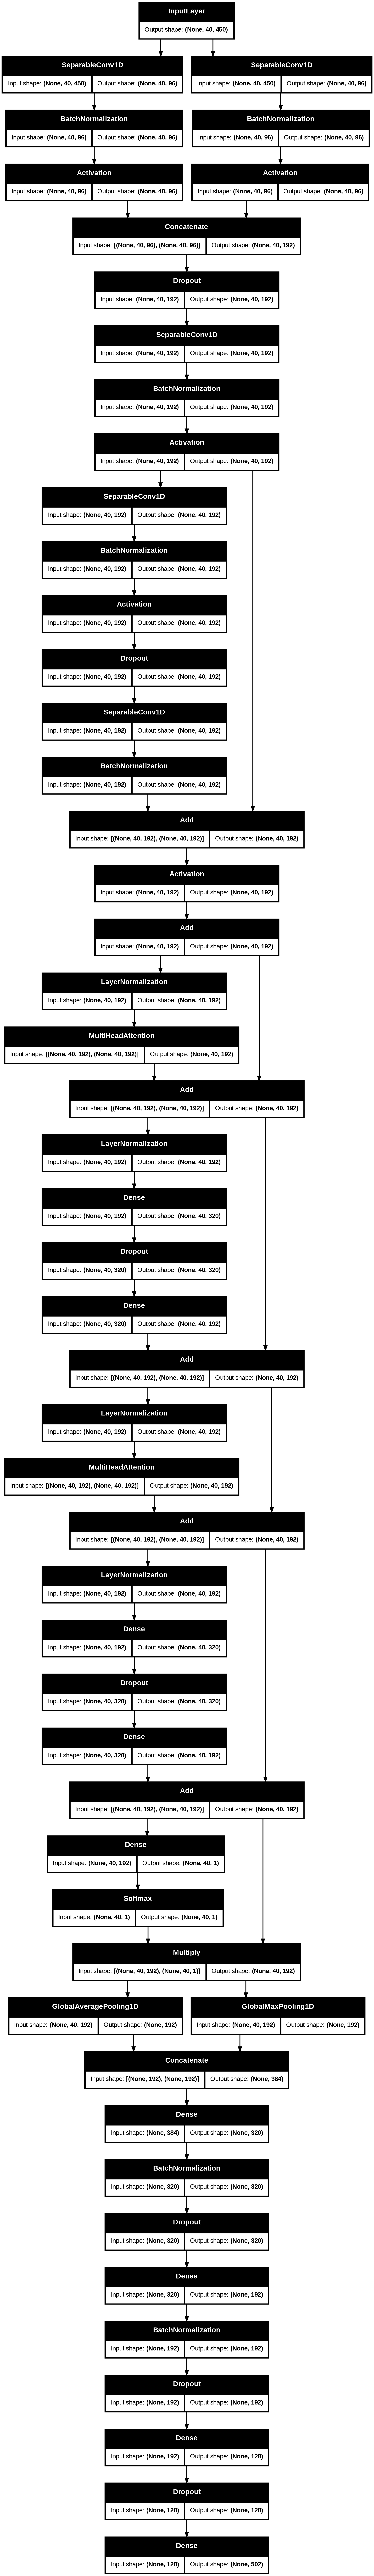

In [19]:
model = create_realtime_model(config.NUM_FRAMES, 450, num_classes)
optimizer = Adam(config.LEARNING_RATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

plot_model(
    model,
    to_file="model_architecture.png",
    show_shapes=True,
    show_layer_names=False,
    expand_nested=True,
    dpi=200
)

display(Image(filename="model_architecture.png"))

In [20]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = f"Transformer_{timestamp}"
callbacks = [
    EarlyStopping(monitor='val_loss', patience=config.PATIENCE, restore_best_weights=True),
    ModelCheckpoint(filepath=os.path.join(config.MODEL_DIR, f'{model_name}_best.keras'),
                    monitor='val_accuracy', save_best_only=True),
    LearningRateScheduler(cosine_decay_with_warmup, verbose=0)
]

In [21]:
class_weights_array = compute_class_weight('balanced', classes=np.unique(train_samples['class_id']),
                                               y=train_samples['class_id'])
class_weights = dict(enumerate(class_weights_array))
history = model.fit(train_gen, validation_data=val_gen, epochs=config.EPOCHS, callbacks=callbacks,
                        class_weight=class_weights, verbose=2)

# Save history
pd.DataFrame(history.history).to_csv(os.path.join(config.OUTPUT_DIR, f'{model_name}_history.csv'), index=False)
print("✓ Training complete")

Epoch 1/200


I0000 00:00:1768678421.900326     109 service.cc:152] XLA service 0x7d79e400c980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768678421.900383     109 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1768678421.900391     109 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1768678424.335132     109 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1768678441.785578     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1686/1686 - 184s - 109ms/step - accuracy: 0.0134 - loss: 5.7862 - val_accuracy: 0.0622 - val_loss: 4.5424 - learning_rate: 2.0000e-04
Epoch 2/200
1686/1686 - 121s - 72ms/step - accuracy: 0.1378 - loss: 3.7464 - val_accuracy: 0.4047 - val_loss: 2.2231 - learning_rate: 4.0000e-04
Epoch 3/200
1686/1686 - 128s - 76ms/step - accuracy: 0.3492 - loss: 2.3455 - val_accuracy: 0.6098 - val_loss: 1.2915 - learning_rate: 6.0000e-04
Epoch 4/200
1686/1686 - 124s - 74ms/step - accuracy: 0.4996 - loss: 1.6792 - val_accuracy: 0.6635 - val_loss: 1.1116 - learning_rate: 8.0000e-04
Epoch 5/200
1686/1686 - 125s - 74ms/step - accuracy: 0.5763 - loss: 1.3848 - val_accuracy: 0.6298 - val_loss: 1.2299 - learning_rate: 1.0000e-03
Epoch 6/200
1686/1686 - 123s - 73ms/step - accuracy: 0.6471 - loss: 1.1210 - val_accuracy: 0.7826 - val_loss: 0.6449 - learning_rate: 1.0000e-03
Epoch 7/200
1686/1686 - 123s - 73ms/step - accuracy: 0.6993 - loss: 0.9418 - val_accuracy: 0.8428 - val_loss: 0.4739 - learning_rate: 9.9994e

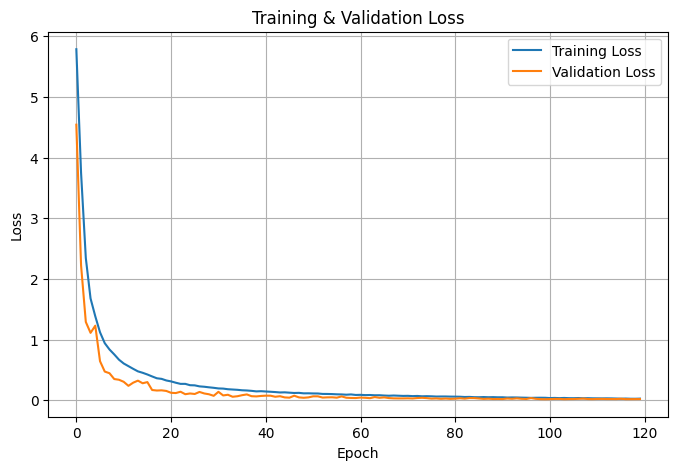

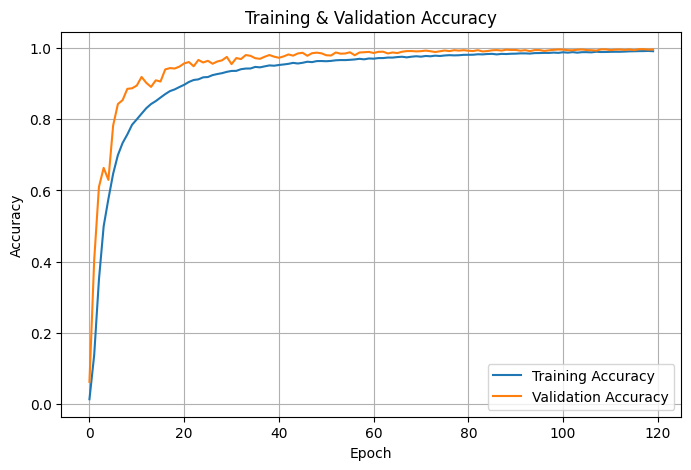

In [22]:
hist_df = pd.DataFrame(history.history)

# Plot Loss
plt.figure(figsize=(8,5))
plt.plot(hist_df['loss'], label='Training Loss')
plt.plot(hist_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_validation_loss.png', dpi=300)
plt.show()

# Plot Accuracy
plt.figure(figsize=(8,5))
plt.plot(hist_df['accuracy'], label='Training Accuracy')
plt.plot(hist_df['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('training_validation_accuracy.png', dpi=300)
plt.show()


In [23]:
print("\n=== Evaluating on Test Set ===")

if len(test_gen) == 0:
    print("ERROR: Test generator is empty! No test data available.")
else:
    y_true = []
    y_true_onehot = []
    y_pred_probs = []

    # Iterate through all test batches
    for batch_idx in range(len(test_gen)):
        X_batch, y_batch = test_gen[batch_idx]

        preds = model.predict(X_batch, verbose=0)

        # Store true and predicted labels
        y_true.extend(np.argmax(y_batch, axis=1))
        y_true_onehot.append(y_batch)
        y_pred_probs.append(preds)

    y_true_onehot = np.vstack(y_true_onehot)
    y_pred_probs = np.vstack(y_pred_probs)

    # Top-1 accuracy
    top1 = np.mean(np.array(y_true) == np.argmax(y_pred_probs, axis=1))

    # Top-5 accuracy
    top5 = np.mean([np.argmax(y_true_onehot[i]) in np.argsort(y_pred_probs[i])[-5:] for i in range(len(y_true))])

    # Top-10 accuracy
    top10 = np.mean([np.argmax(y_true_onehot[i]) in np.argsort(y_pred_probs[i])[-10:] for i in range(len(y_true))])

    print(f"\nTotal test samples evaluated: {len(y_true)}")
    print(f"Test Accuracy → Top-1: {top1*100:.2f}%, Top-5: {top5*100:.2f}%, Top-10: {top10*100:.2f}%")

    # Classification report (Top-1 only)
    report = classification_report(y_true, np.argmax(y_pred_probs, axis=1), digits=4)
    print("\nClassification Report (Top-1):\n", report)

    # Confusion matrix (Top-1 only)
    cm = confusion_matrix(y_true, np.argmax(y_pred_probs, axis=1))
    print("\nConfusion Matrix (Top-1):\n", cm)

    # Save results
    np.savetxt(os.path.join(config.OUTPUT_DIR, f"{model_name}_confusion_matrix.csv"), cm, delimiter=",", fmt='%d')
    with open(os.path.join(config.OUTPUT_DIR, f"{model_name}_classification_report.txt"), 'w', encoding='utf-8') as f:
        f.write(report)
        f.write(f"\n\nTest Accuracy → Top-1: {top1:.4f}, Top-5: {top5:.4f}, Top-10: {top10:.4f}")


=== Evaluating on Test Set ===

Total test samples evaluated: 12046
Test Accuracy → Top-1: 99.20%, Top-5: 99.85%, Top-10: 99.92%

Classification Report (Top-1):
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        24
           1     1.0000    1.0000    1.0000        24
           2     1.0000    1.0000    1.0000        24
           3     1.0000    0.9583    0.9787        24
           4     0.9688    1.0000    0.9841        31
           5     0.8947    1.0000    0.9444        17
           6     1.0000    1.0000    1.0000        24
           7     1.0000    1.0000    1.0000        24
           8     1.0000    1.0000    1.0000        24
           9     1.0000    1.0000    1.0000        24
          10     1.0000    0.9583    0.9787        24
          11     1.0000    1.0000    1.0000        24
          12     1.0000    0.9167    0.9565        24
          13     0.9231    1.0000    0.9600        24
          14     1.0000   

In [24]:
def evaluate_prefix_accuracy(model, generator, prefixes=[0.25, 0.5, 0.75, 1.0]):
    prefix_acc = {}
    
    for p in prefixes:
        y_true_all = []
        y_pred_probs_all = []

        for i in range(len(generator)):
            X_batch, y_batch = generator[i]  # X_batch shape: (B, T, F)
            T = X_batch.shape[1]
            cutoff = max(1, int(T * p))  # at least 1 frame
            
            X_prefix = X_batch[:, :cutoff, :]
            
            # Pad if necessary
            if cutoff < T:
                padding = np.zeros((X_batch.shape[0], T - cutoff, X_batch.shape[2]), dtype=X_batch.dtype)
                X_prefix = np.concatenate([X_prefix, padding], axis=1)
            
            preds = model.predict(X_prefix, verbose=0)
            
            y_true_all.extend(np.argmax(y_batch, axis=1))
            y_pred_probs_all.append(preds)

        y_pred_probs_all = np.vstack(y_pred_probs_all)
        y_true_all = np.array(y_true_all)

        # Top-1
        top1 = np.mean(y_true_all == np.argmax(y_pred_probs_all, axis=1))

        # Top-5
        top5 = np.mean([y_true_all[i] in np.argsort(y_pred_probs_all[i])[-5:] for i in range(len(y_true_all))])

        # Top-10
        top10 = np.mean([y_true_all[i] in np.argsort(y_pred_probs_all[i])[-10:] for i in range(len(y_true_all))])

        prefix_acc[p] = {'top1': top1, 'top5': top5, 'top10': top10}
        print(f"Prefix {int(p*100)}% frames → Top-1: {top1*100:.2f}%, Top-5: {top5*100:.2f}%, Top-10: {top10*100:.2f}%")
    
    # Optional: plot Top-1 only
    plt.figure(figsize=(6,4))
    plt.plot([int(f*100) for f in prefixes], [v['top1']*100 for v in prefix_acc.values()], marker='o', label='Top-1')
    plt.plot([int(f*100) for f in prefixes], [v['top5']*100 for v in prefix_acc.values()], marker='o', label='Top-5')
    plt.plot([int(f*100) for f in prefixes], [v['top10']*100 for v in prefix_acc.values()], marker='o', label='Top-10')
    plt.xlabel("Frames Seen (%)")
    plt.ylabel("Accuracy (%)")
    plt.title("Prefix / Causal Accuracy")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    return prefix_acc


Prefix 25% frames → Top-1: 5.27%, Top-5: 14.46%, Top-10: 22.25%
Prefix 50% frames → Top-1: 45.71%, Top-5: 69.92%, Top-10: 78.07%
Prefix 75% frames → Top-1: 91.32%, Top-5: 98.03%, Top-10: 98.90%
Prefix 100% frames → Top-1: 99.20%, Top-5: 99.85%, Top-10: 99.92%


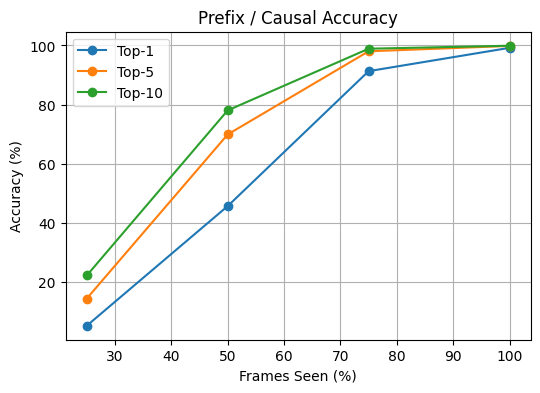

In [25]:
# Example: evaluate causal accuracy on your test generator
prefix_results = evaluate_prefix_accuracy(model, test_gen, prefixes=[0.25, 0.5, 0.75, 1.0])

In [26]:
X_batch, _ = test_gen[0]

start = time.time()
_ = model.predict(X_batch[:1], verbose=0)
latency = (time.time() - start) * 1000

print(f"Inference latency: {latency:.2f} ms")

Inference latency: 3660.61 ms
